In [1]:
import yaml
from fv3net.diagnostics.prognostic_run.load_run_data import SegmentedRun, CatalogSimulation, evaluation_pair_to_input_data, load_grid
from vcm.catalog import catalog
import fv3viz
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

In [2]:
with open('run_urls.yaml') as f:
    runs = yaml.safe_load(f)
url_fine_only = runs['prog-35day-seed5']['url']
url_n2f = runs['n2f-35day']['url']
url_baseline = runs['baseline-35day']['url']

In [3]:
grid = load_grid(catalog)

In [4]:
run = SegmentedRun(url_fine_only, catalog)
run_n2f = SegmentedRun(url_n2f, catalog)
run_baseline = SegmentedRun(url_baseline, catalog)
verif = CatalogSimulation('40day_may2020', catalog)

In [5]:
data = evaluation_pair_to_input_data(run, verif, grid)

/home/OliWM/repos/fv3net/workflows/diagnostics/fv3net/diagnostics/prognostic_run/load_run_data.py:122: UserWarning: gs://vcm-ml-experiments/default/2023-01-12/ml-on-fine-ensemble-prog-rad-l-5-trial-0/fv3gfs_run/nudging_tendencies.zarr not found. Returning empty dataset.
  warnings.warn(UserWarning(f"{path} not found. Returning empty dataset."))
/home/OliWM/repos/fv3net/workflows/diagnostics/fv3net/diagnostics/prognostic_run/load_run_data.py:122: UserWarning: gs://vcm-ml-experiments/default/2023-01-12/ml-on-fine-ensemble-prog-rad-l-5-trial-0/fv3gfs_run/piggy.zarr not found. Returning empty dataset.
  warnings.warn(UserWarning(f"{path} not found. Returning empty dataset."))


In [6]:
data_n2f = evaluation_pair_to_input_data(run_n2f, verif, grid)

/home/OliWM/repos/fv3net/workflows/diagnostics/fv3net/diagnostics/prognostic_run/load_run_data.py:122: UserWarning: gs://vcm-ml-experiments/default/2023-01-12/ml-on-fine-n2f-prog-rad-trial-0/fv3gfs_run/nudging_tendencies.zarr not found. Returning empty dataset.
  warnings.warn(UserWarning(f"{path} not found. Returning empty dataset."))
/home/OliWM/repos/fv3net/workflows/diagnostics/fv3net/diagnostics/prognostic_run/load_run_data.py:122: UserWarning: gs://vcm-ml-experiments/default/2023-01-12/ml-on-fine-n2f-prog-rad-trial-0/fv3gfs_run/piggy.zarr not found. Returning empty dataset.
  warnings.warn(UserWarning(f"{path} not found. Returning empty dataset."))


In [7]:
data_baseline = evaluation_pair_to_input_data(run_baseline, verif, grid)

/home/OliWM/repos/fv3net/workflows/diagnostics/fv3net/diagnostics/prognostic_run/load_run_data.py:122: UserWarning: gs://vcm-ml-experiments/default/2022-11-21/ml-on-fine-baseline-long-trial-0/fv3gfs_run/nudging_tendencies.zarr not found. Returning empty dataset.
  warnings.warn(UserWarning(f"{path} not found. Returning empty dataset."))
/home/OliWM/repos/fv3net/workflows/diagnostics/fv3net/diagnostics/prognostic_run/load_run_data.py:122: UserWarning: gs://vcm-ml-experiments/default/2022-11-21/ml-on-fine-baseline-long-trial-0/fv3gfs_run/piggy.zarr not found. Returning empty dataset.
  warnings.warn(UserWarning(f"{path} not found. Returning empty dataset."))


In [8]:
data_2d_prog = data['2d'][0]
data_2d_verif = data['2d'][1]
data_2d_n2f = data_n2f['2d'][0]
data_2d_baseline = data_baseline['2d'][0]

In [9]:
variables = ['column_integrated_Q1', 'column_integrated_Q2', 'total_precip_to_surface', 'water_vapor_path']

In [10]:
data = xr.concat(
    [
        data_2d_baseline[variables].assign_coords(run='baseline'),
        data_2d_prog[variables].assign_coords(run='ML-physics'),
        data_2d_n2f[variables].assign_coords(run='nudge-to-fine'),
        data_2d_verif[variables].assign_coords(run='fine-res'),
    ],
    'run'
)
data['total_precip_to_surface'].attrs['long_name'] = 'Surface precipitation rate'

In [11]:
plotme = data.isel(time=slice(96*4 + 11, 96*8 + 11, 96))
plotme = xr.merge([plotme, grid]).load()

In [12]:
plotme2 = data.sel(time='2016-08-08T00:00:00').squeeze()
plotme2 = xr.merge([plotme2, grid]).load()

In [13]:
plotme4 = data.sel(time='2016-08-09T00:00:00').squeeze()
plotme4 = xr.merge([plotme4, grid]).load()

In [14]:
plotme3 = data.isel(time=slice(96*4 + 11, 96*5 + 11, 12))
plotme3 = xr.merge([plotme3, grid]).load()

In [15]:
def plot_maps(ds, var, **kwargs):
    coastlines_kwargs = dict(linewidth=0.7)
    fg = fv3viz.plot_cube(ds, var, col='time', row='run', coastlines_kwargs=coastlines_kwargs, **kwargs)[-1]
    fg.set_titles(template='{value}')
    fg.fig.set_size_inches((14, 6))

In [16]:
def plot_maps_single_time(ds, var, **kwargs):
    coastlines_kwargs = dict(linewidth=0.7)
    fg = fv3viz.plot_cube(ds, var, col='run', col_wrap=2, coastlines_kwargs=coastlines_kwargs, **kwargs)[-1]
    fg.set_titles(template='{value}')
    fg.fig.set_size_inches((6, 3.5))
    fg.fig.suptitle(ds.time.values.item())

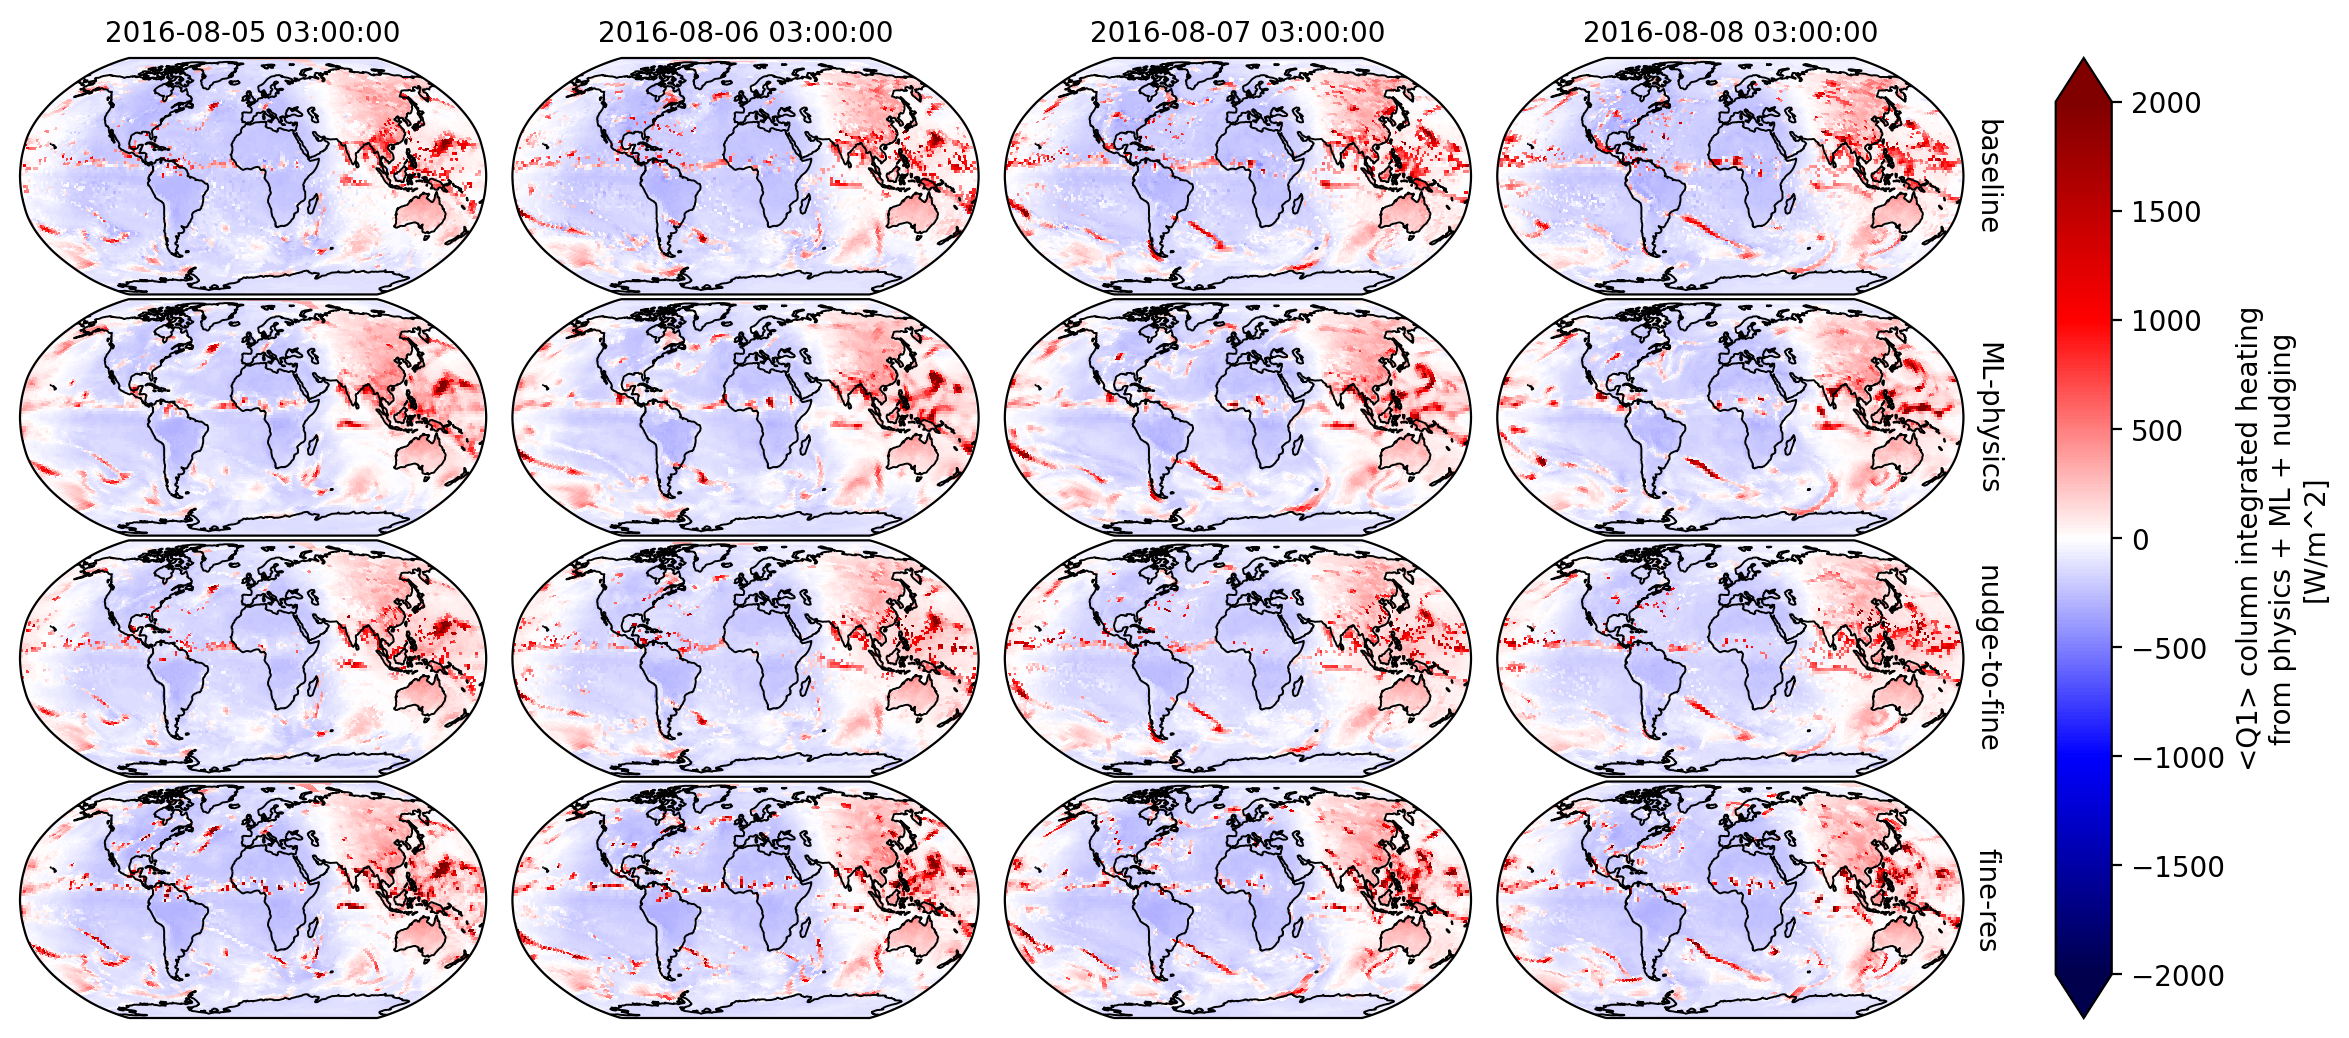

In [17]:
plot_maps(plotme, 'column_integrated_Q1', vmin=-2000, vmax=2000, cmap='seismic')

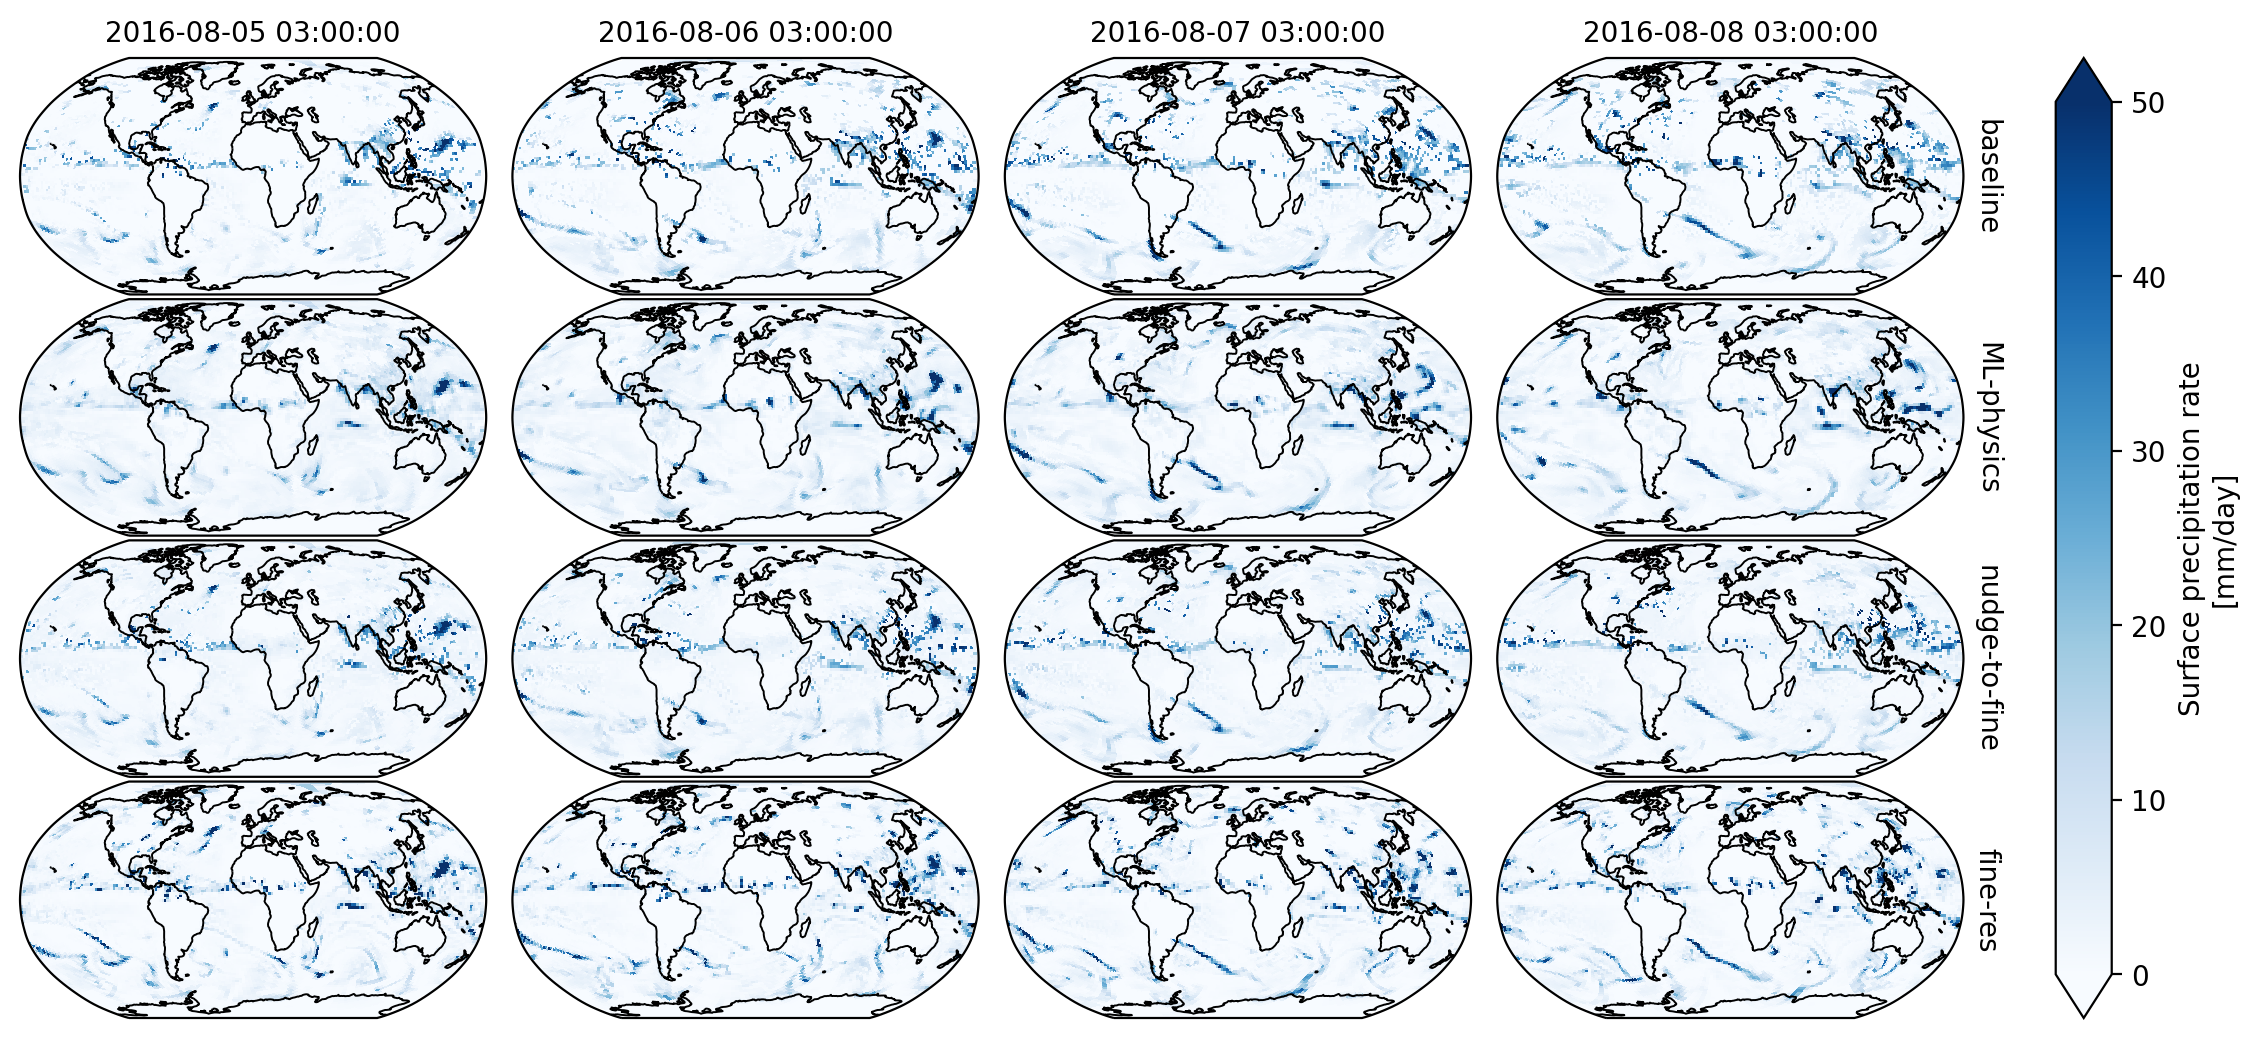

In [18]:
plot_maps(plotme, 'total_precip_to_surface', vmin=0, vmax=50, cmap='Blues')

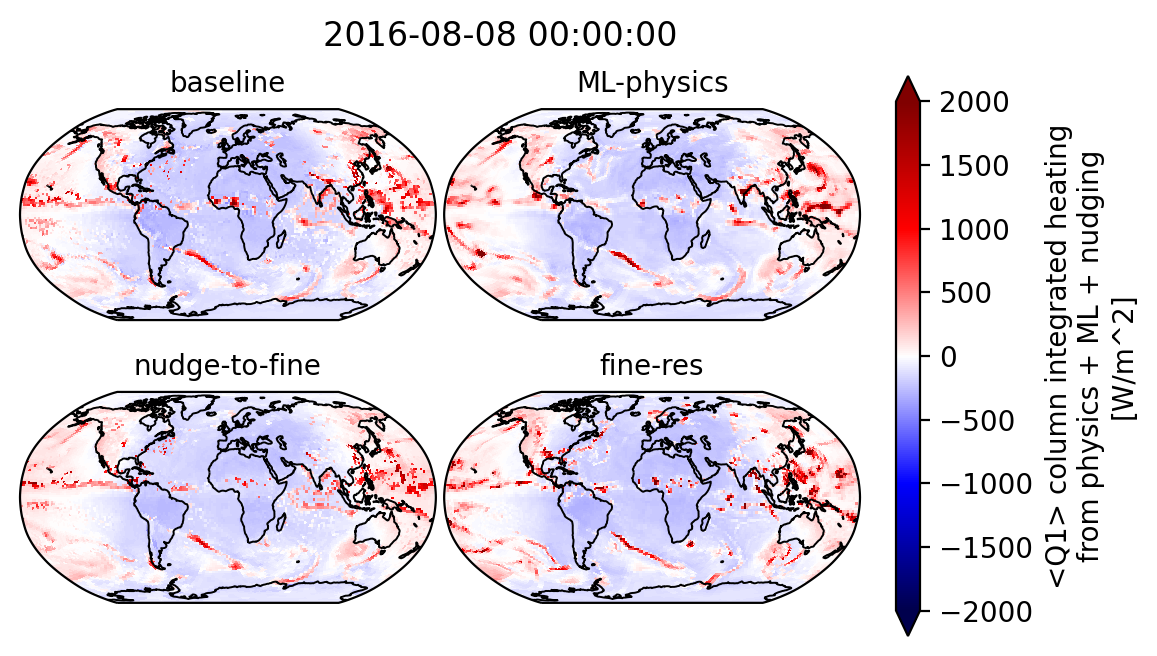

In [19]:
plot_maps_single_time(plotme2, 'column_integrated_Q1', vmin=-2000, vmax=2000, cmap='seismic')

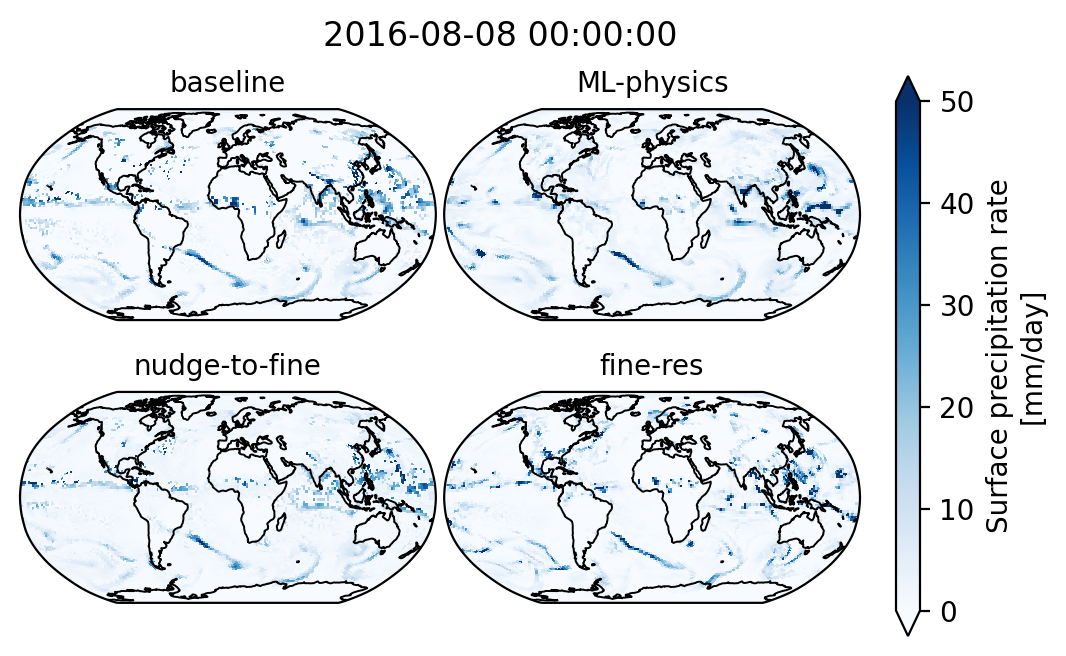

In [20]:
plot_maps_single_time(plotme2, 'total_precip_to_surface', vmin=0, vmax=50, cmap='Blues')

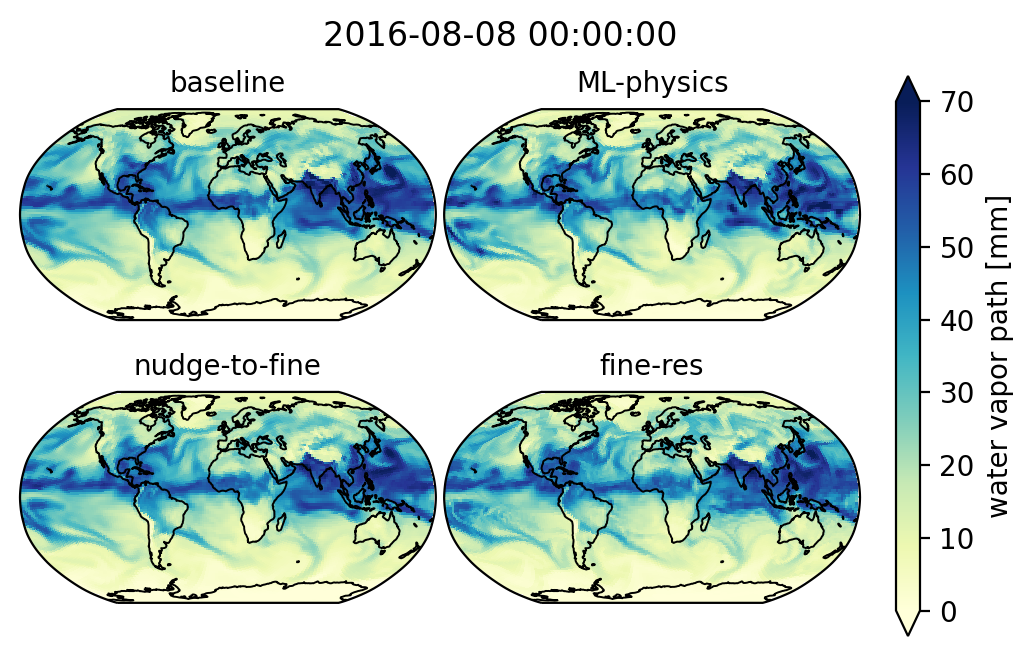

In [21]:
plot_maps_single_time(plotme2, 'water_vapor_path', vmin=0, vmax=70, cmap='YlGnBu')

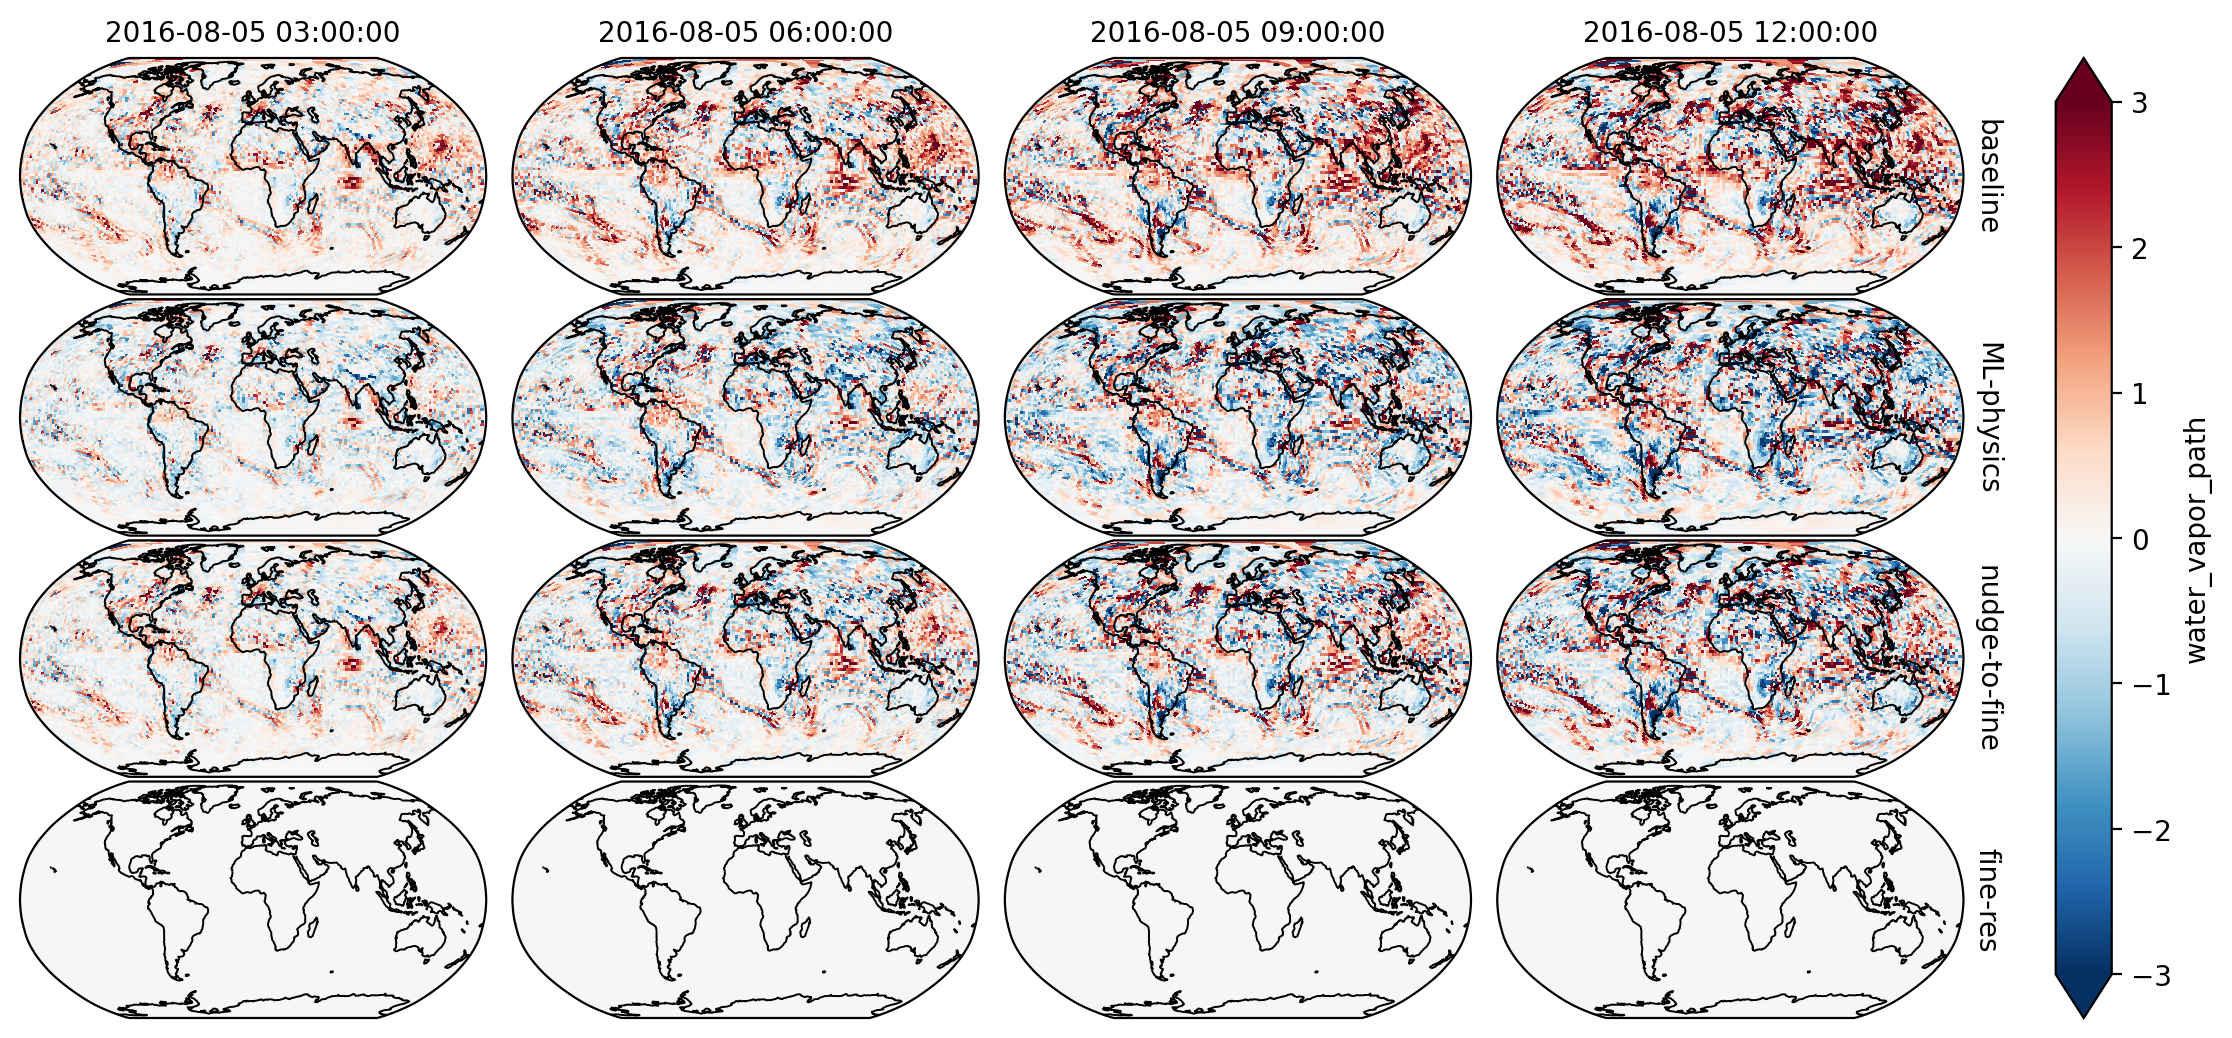

In [22]:
error = plotme3 - plotme3.sel(run='fine-res')
error = xr.merge([grid, error], compat='override')
plot_maps(error.isel(time=slice(None, 4)), 'water_vapor_path', vmin=-3, vmax=3, cmap='RdBu_r')

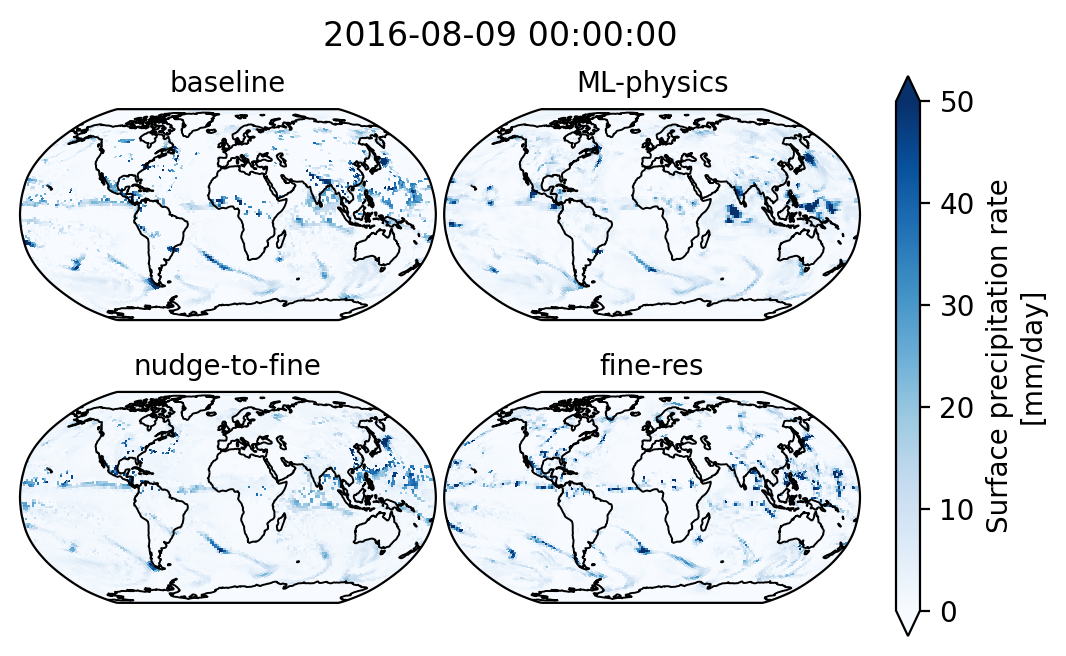

In [23]:
plot_maps_single_time(plotme4, 'total_precip_to_surface', vmin=0, vmax=50, cmap='Blues')